In [47]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import os
os.environ['R_HOME'] = 'D:/Program Files/R-4.5.0' #@TODO include in some setup file

from simulation_engine.scenarios.iv.binary_iv import BinaryIV
from simulation_engine.scenarios.iv.continuous_iv import ContinuousIV
from simulation_engine.scenarios.iv.base_iv import IVScenario
from simulation_engine.util.plotting_util import PlottingUtil
from simulation_engine.algorithms.causaloptim import Causaloptim
import pandas as pd
pd.set_option('display.max_columns', None)


#disable warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from simulation_engine.algorithms.zaffalonbounds import ZaffalonBounds

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
data = BinaryIV.generate_data_rolling_ate(N_simulations=10)


In [ ]:
binaryIV = BinaryIV('IV Dag', data)

binaryIV.bound_ate_2SLS()
binaryIV.bound_ate_causaloptim()
binaryIV.bound_ate_autobound()
binaryIV.bound_ate_entropy(entr=0.80)
binaryIV.bound_ate_zaffalon_parallel()
binaryIV.bound_ate_manski()

data

Running Zaffalon bounds in parallel...


,seed,intercept_X,intercept_Y,b_Z,b_U_X,b_X_Y,b_U_Y,ATE_true,p_Y1_mean,p_Y0_mean,p_U,p_Z,Z,U,X,Y,entropy_Z,entropy_U,entropy_X,entropy_Y,2SLS_bound_lower,2SLS_bound_upper,2SLS_bound_valid,2SLS_bound_width,2SLS_bound_failed,causaloptim_bound_lower,causaloptim_bound_upper,causaloptim_bound_valid,causaloptim_bound_width,causaloptim_bound_failed,autobound_bound_lower,autobound_bound_upper,autobound_bound_valid,autobound_bound_width,autobound_bound_failed,entropybounds_bound_lower,entropybounds_bound_upper,entropybounds_bound_valid,entropybounds_bound_width,entropybounds_bound_failed,entropybounds_H(conf)_UB,zaffalonbounds_bound_lower,zaffalonbounds_bound_upper,zaffalonbounds_bound_valid,zaffalonbounds_bound_width,zaffalonbounds_bound_failed,manski_bound_lower,manski_bound_upper,manski_bound_valid,manski_bound_width,manski_bound_failed
0,494734,0,0,-1.031856,-0.332581,-5.0,-1.145755,-0.314873,0.003495,0.318368,0.695629,0.035035,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, ...","[0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",0.173917,0.878832,0.987394,0.721928,-1.000000,0.566421,True,1.566421,False,-0.613331,0.163007,True,0.776339,False,-0.613331,0.178013,True,0.791344,False,-0.714999,0.252913,True,0.967911,False,0.8,-0.5380,0.0195,True,0.5575,False,-0.990783,0.300353,True,1.291137,False
1,819240,0,0,-1.352472,0.604338,-4.0,-0.210963,-0.438150,0.014979,0.453129,0.882956,0.113622,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, ...","[1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.546365,0.493854,0.981454,0.697269,-0.808899,-0.082630,True,0.726269,False,-0.499982,-0.125894,True,0.374087,False,-0.555556,0.069267,True,0.624823,False,-0.775991,0.210426,True,0.986417,False,0.8,-0.5821,-0.1987,True,0.3834,False,-0.951724,0.171429,True,1.123153,False
2,773949,0,0,1.370825,1.051988,-3.0,-0.894142,-0.327535,0.028581,0.356115,0.688884,0.374599,"[1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, ...",0.949124,0.897737,0.847146,0.529361,-0.476828,0.033292,True,0.510120,False,-0.662975,-0.083586,True,0.579389,False,-0.734108,0.030132,True,0.764241,False,-0.845001,0.155000,True,1.000001,False,0.8,-0.5001,-0.2063,True,0.2938,False,-0.950413,0.255474,True,1.205888,False
3,155467,0,0,1.845052,-0.819024,-2.0,0.606094,-0.409943,0.153582,0.563525,0.437352,0.298242,"[0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, ...","[1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, ...","[1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, ...",0.895469,0.986617,0.997737,0.944331,-0.556699,-0.121422,True,0.435277,False,-0.614788,-0.085420,True,0.529368,False,-0.614788,-0.039952,True,0.574836,False,-0.687992,0.312001,True,0.999993,False,0.8,-0.5183,-0.0936,True,0.4247,False,-0.712121,-0.211864,True,0.500257,False
4,917825,0,0,-0.788225,0.950941,-1.0,-1.399723,-0.220816,0.252596,0.473412,0.101618,0.524604,"[0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, ...","[1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, ...",0.996662,0.429759,0.989588,0.962170,-0.479814,0.566579,True,1.046394,False,-0.522384,0.266770,True,0.789153,False,-0.522384,0.280867,True,0.803250,False,-0.617990,0.381994,True,0.999984,False,0.8,-0.3292,0.0939,True,0.4231,False,-0.536364,-0.014286,True,0.522078,False
5,488106,0,0,-1.399469,-1.341374,0.0,0.938351,0.000000,0.502188,0.502188,0.002852,0.764243,"[1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, ...",0.7

Algorithm: causaloptim
  Fail Rate: 0.00%
  Invalid Rate: 0.00%
  Net Bound Width: 0.64177126014859
Algorithm: 2SLS
  Fail Rate: 0.00%
  Invalid Rate: 0.00%
  Net Bound Width: 0.9232279505376999
Algorithm: autobound
  Fail Rate: 0.00%
  Invalid Rate: 0.00%
  Net Bound Width: 0.719526813712161
Algorithm: entropybounds
  Fail Rate: 0.00%
  Invalid Rate: 0.00%
  Net Bound Width: 0.9945671418241189
Algorithm: zaffalonbounds
  Fail Rate: 0.00%
  Invalid Rate: 10.00%
  Net Bound Width: 0.42196666666666666
Algorithm: manski
  Fail Rate: 0.00%
  Invalid Rate: 20.00%
  Net Bound Width: 0.8597372822095546


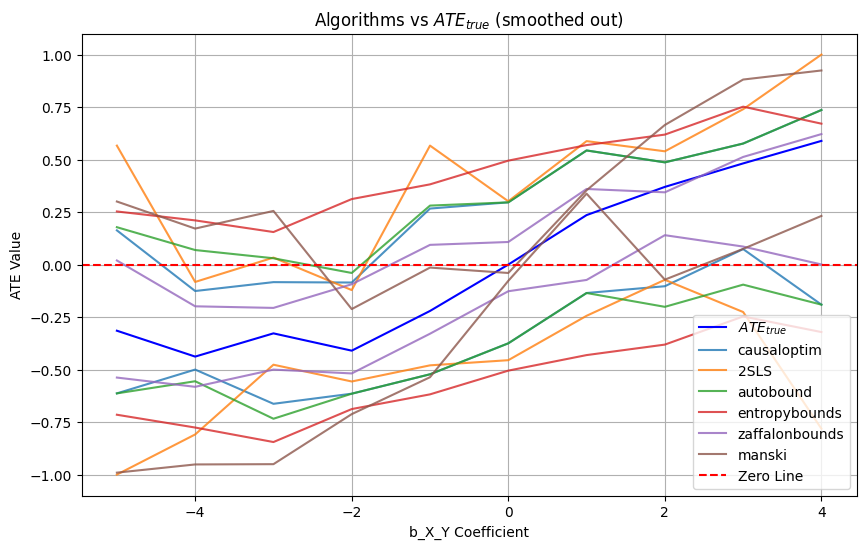

In [43]:
binaryIV.data
algorithms = ['causaloptim', '2SLS', 'autobound', 'entropybounds', 'zaffalonbounds', 'manski']
PlottingUtil.print_bound_statistics(binaryIV.data, algorithms)
PlottingUtil.plot_smoothed_ate_vs_bounds(binaryIV.data, algorithms, 1)


In [9]:
invalids = binaryIV.data[binaryIV.data['causaloptim_bound_valid'] == False]
invalIV = BinaryIV('IV Dag', invalids)
invalIV.bound_ate_causaloptim()
invalIV.data

caputured: R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In boundsfunc(p00_0 = p00_0, p00_1 = p00_1, p10_0 = p10_0, p10_1 = p10_1,  :
R[write to console]: 
 
R[write to console]:  Invalid bounds! Data probably does not satisfy the assumptions in the DAG!


Invalid Bounds detected
caputured: 
caputured: 


,seed,intercept_X,intercept_Y,b_Z,b_U_X,b_X_Y,b_U_Y,ATE_true,p_Y1_mean,p_Y0_mean,p_U,p_Z,Z,U,X,Y,entropy_Z,entropy_U,entropy_X,entropy_Y,causaloptim_bound_lower,causaloptim_bound_upper,causaloptim_bound_valid,causaloptim_bound_width,causaloptim_bound_failed
3,944243,0,0,2.264300,-0.893513,-4.7,-0.207546,-0.448266,0.007581,0.455847,0.866774,0.819945,"[1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",0.705637,0.599739,0.849943,0.517753,-0.344369,-0.348804,False,-0.004435,False
49,877939,0,0,-1.917451,1.823300,-0.1,-1.612648,-0.013956,0.168286,0.182243,0.949875,0.809191,"[1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.697269,0.277840,0.998049,0.614823,-0.157216,-0.107379,False,0.049838,False
90,220567,0,0,-1.028126,-2.033834,4.0,0.054696,0.472237,0.982737,0.510499,0.792267,0.222949,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, ...","[1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, ...","[1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, ...",0.737642,0.781481,0.653109,0.963497,-0.282440,0.451923,False,0.734363,False
